In [14]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from anndata import AnnData
from tqdm import tqdm

from scellst.constant import PREDS_DIR, METRICS_DIR
from scellst.dataset.data_handler import XeniumHandler
from scellst.metrics.metric_utils import format_metric_df
from scellst.plots.plot_spatial import plot_top_genes
from scellst.utils import split_to_dict
from sCellST_reproducibility.reproducibility_notebooks.utils_analyses import load_predictions
from sCellST_reproducibility.reproducibility_notebooks.utils_plot import plot_he


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
data_dir = Path("../../hest_data")
save_path = Path(f"figures/xenium")
save_path.mkdir(exist_ok=True)

In [16]:
def rotate_image(adata: AnnData) -> AnnData:
    adata.uns["spatial"]["ST"]["images"]["downscaled_fullres"] = np.swapaxes(
        adata.uns["spatial"]["ST"]["images"]["downscaled_fullres"], 0, 1)
    adata.obsm["spatial"] = adata.obsm["spatial"][:, [1, 0]]
    return adata

In [17]:
def crop_image(adata: AnnData, x_min: int, x_max: str, y_min: str, y_max: str) -> AnnData:
    # Crop image
    img = adata.uns["spatial"]["ST"]["images"]["downscaled_fullres"]
    scale_factor = adata.uns["spatial"]["ST"]["scalefactors"]["tissue_downscaled_fullres_scalef"]

    y_min_ = int(y_min * scale_factor)
    y_max_ = int(y_max * scale_factor)
    x_min_ = int(x_min * scale_factor)
    x_max_ = int(x_max * scale_factor)
    adata.uns["spatial"]["ST"]["images"]["downscaled_fullres"] = img[y_min_:y_max_, x_min_:x_max_, :]

    # Adapt spatial coordinates
    adata.obsm["spatial"][:, 0] -= x_min
    adata.obsm["spatial"][:, 1] -= y_min

    return adata

In [18]:
def plot_xenium_exp(
        prediction_adata_path: Path,
        data_dir: Path,
        slide_id: str,
        list_genes: list[str],
        save_path: Path
) -> None:
    # Output
    save_path = save_path / slide_id
    save_path.mkdir(exist_ok=True)

    # Load data
    cell_adata_pred = load_predictions(prediction_adata_path)
    cell_adata = XeniumHandler().load_and_preprocess_data(
        data_dir, slide_id, filter_genes=False, filter_cells=False, normalize=True, log1p=True, embedding_path=None
    )
    cell_adata.X = cell_adata.X.toarray()

    # Rotate image
    if slide_id == "TENX95":
        rotate_image(cell_adata)
        rotate_image(cell_adata_pred)
        cell_adata = crop_image(cell_adata, x_min=2500, x_max=53738, y_min=400, y_max=47000)
        cell_adata_pred = crop_image(cell_adata_pred, x_min=2500, x_max=53738, y_min=400, y_max=47000)
    plot_he(cell_adata, title=f"{slide_id} H&E", save_path=save_path / f"he_{slide_id}.png")

    for gene in list_genes:
        print(f"Plotting: {gene}")
        plot_top_genes(cell_adata, cell_adata_pred, gene, save_path / f"{gene}.png")
    return cell_adata

15:42:09 INFO: Loading data for ID: NCBI785


/home/loic/miniconda3/envs/CellST/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


15:42:10 INFO: Loaded adata with shape: (167780, 541)
15:42:10 INFO: After mt and rps filtering: 541
15:42:10 INFO: Normalising spot counts.


/home/loic/miniconda3/envs/CellST/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


15:42:10 INFO: Log1p transform counts.
15:42:10 INFO: Preprocessing completed.
Plotting: KRT8
Plotting: PTPRC


AnnData object with n_obs × n_vars = 167780 × 541
    obs: 'n_counts', 'size_factor'
    var: 'mt'
    uns: 'spatial', 'hest_id', 'log1p', 'cell_embedding_path'
    obsm: 'spatial'
    layers: 'counts'

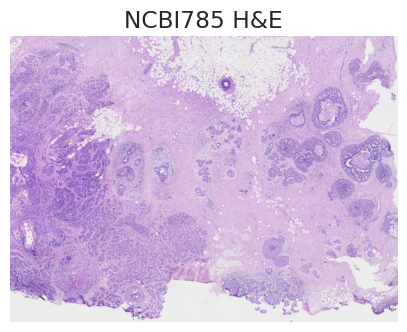

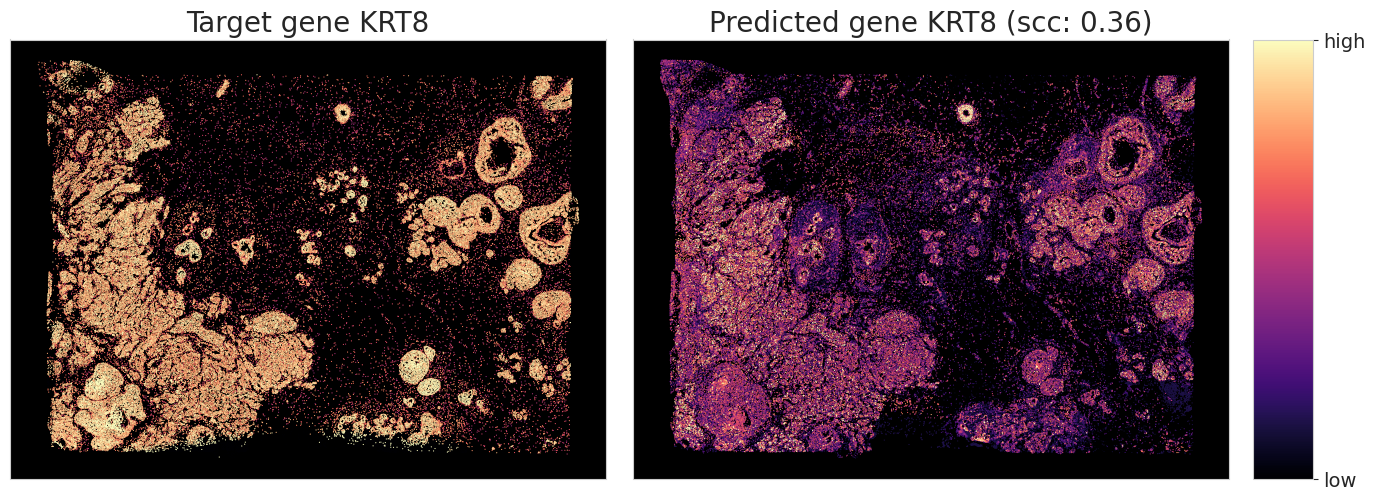

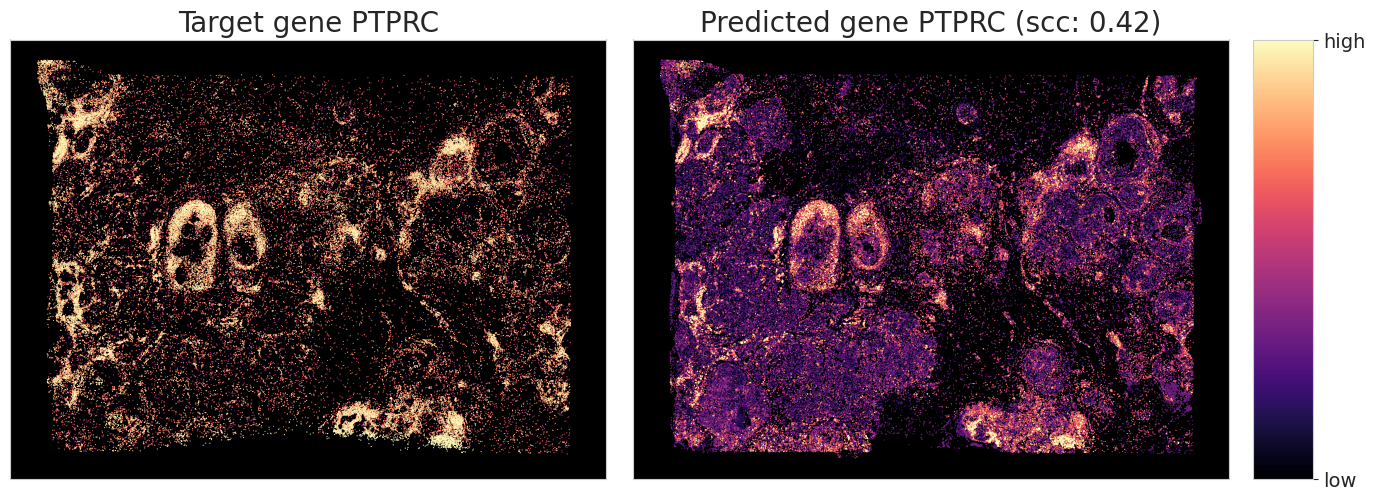

In [19]:
slide_id = "NCBI785"
prediction_adata_path = PREDS_DIR / "xenium" / "xenium" / f"embedding_tag=moco-TENX39-rn50_self;genes=SVG:1000;train_slide=TENX39;test_slide={slide_id};infer_mode=inference.h5ad"
list_genes = ["KRT8", "PTPRC"]

plot_xenium_exp(prediction_adata_path, data_dir, slide_id, list_genes, save_path)

15:43:17 INFO: Loading data for ID: TENX95


/home/loic/miniconda3/envs/CellST/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


15:43:18 INFO: Loaded adata with shape: (574852, 541)
15:43:18 INFO: After mt and rps filtering: 541
15:43:19 INFO: Normalising spot counts.


/home/loic/miniconda3/envs/CellST/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


15:43:20 INFO: Log1p transform counts.
15:43:20 INFO: Preprocessing completed.
Plotting: CD3E
Plotting: EPCAM


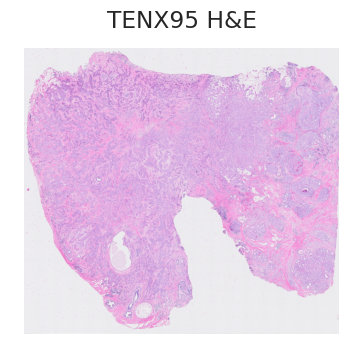

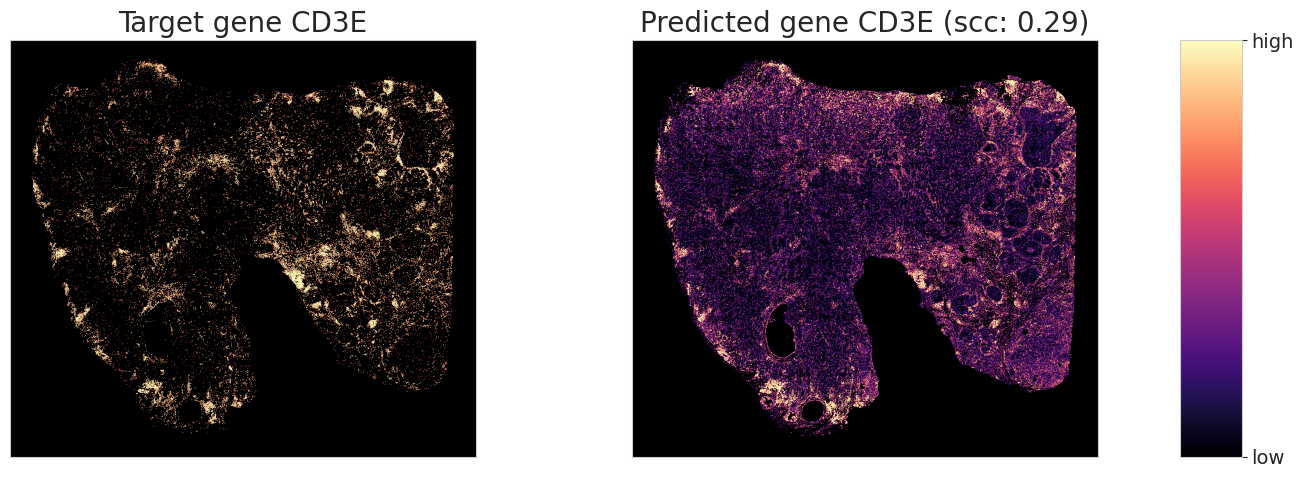

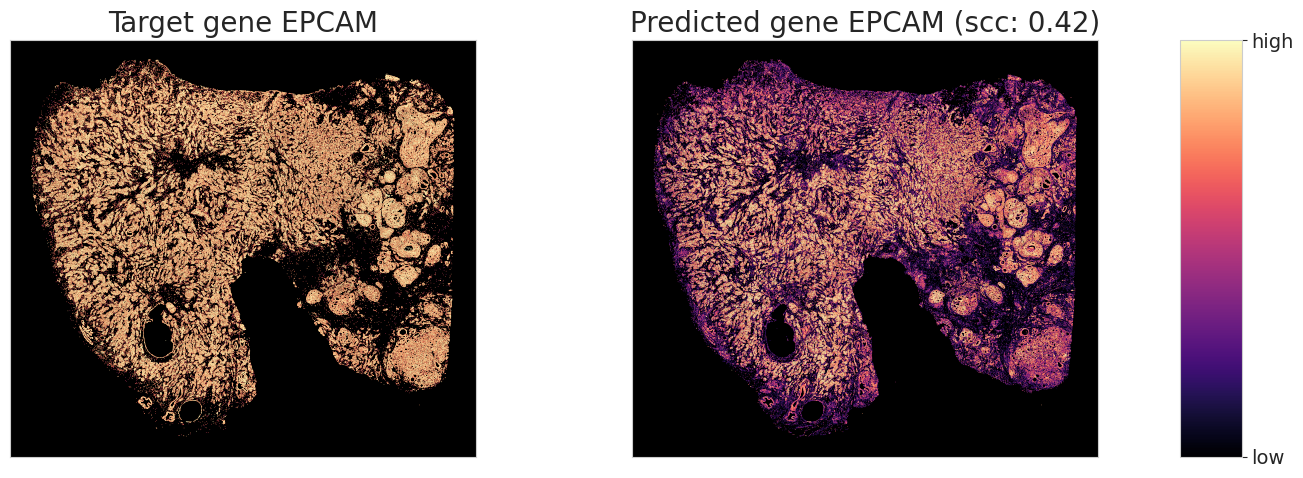

In [20]:
slide_id = "TENX95"
prediction_adata_path = PREDS_DIR / "xenium" / "xenium" / f"embedding_tag=moco-TENX39-rn50_self;genes=SVG:1000;train_slide=TENX39;test_slide={slide_id};infer_mode=inference.h5ad"
list_genes = ["CD3E", "EPCAM"]

cell_adata = plot_xenium_exp(prediction_adata_path, data_dir, slide_id, list_genes, save_path)

In [21]:
# Prepare paths
metrics_dir = METRICS_DIR / "xenium" / "xenium"
metrics_paths = list(metrics_dir.iterdir())
print(f"Found {len(metrics_paths)} paths")

Found 2 paths


In [22]:
# Load metric results
all_df = []
for path in tqdm(metrics_paths):
    if not path.exists():
        print(f"Path {path} does not exist")
        continue
    df = pd.read_csv(path, index_col=0)
    df["tag"] = path.stem
    all_df.append(df)
metrics = pd.concat(all_df).reset_index(drop=True)

# Format metrics for plotting
metrics = format_metric_df(metrics)

# Apply formatting
df_hp = pd.DataFrame(metrics["tag"].apply(split_to_dict).to_list())
metrics = pd.concat([metrics, df_hp], axis=1)

100%|██████████| 2/2 [00:00<00:00, 185.29it/s]


In [23]:
metrics = metrics.rename(columns={"test_slide": "test slide"})

test slide
NCBI785    0.163866
TENX95     0.195626
Name: scc, dtype: float64
test slide
NCBI785    101
TENX95     101
dtype: int64


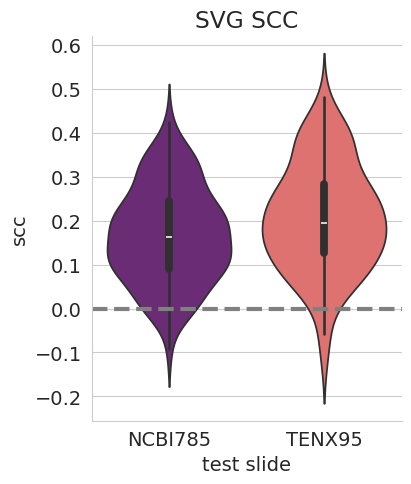

In [24]:
print(metrics.groupby("test slide")["scc"].median())
print(metrics.groupby("test slide").size())

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
sns.violinplot(data=metrics, x="test slide", y="scc", hue="test slide", palette="magma")
ax.set_title("SVG SCC")
ax.axhline(y=0, color='gray', linestyle='--', linewidth=3)
sns.despine()
fig.savefig(save_path / "scc_dist.png", bbox_inches="tight", dpi=100)